In [1]:
import pandas as pd
import re
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

from code.holiday import get_holiday

### Import data

In [2]:
price_df_raw = pd.read_csv('data/MCP-25032018-28032021.csv')
load_df_raw = pd.read_csv('data/LoadForecast-01042018-28032021.csv')
# after 03/10/2018 -> permanent +03 gmt

In [15]:
exchange_df_raw = pd.read_excel('data/exchange_rates_from_CBRT.xlsx')

In [19]:
exchange_df = exchange_df_raw.dropna() \
    .rename(
        columns={
            'TP DK USD A YTL': 'USD_TRY_buy',
            'TP DK USD S YTL': 'USD_TRY_sell',
            'TP DK EUR A YTL': 'EUR_TRY_buy',
            'TP DK EUR S YTL': 'EUR_TRY_sell',
        }
    ) \
    .assign(
        USD_TRY = lambda df: (df.USD_TRY_buy + df.USD_TRY_sell) / 2,
        EUR_TRY = lambda df: (df.EUR_TRY_buy + df.EUR_TRY_sell) / 2,
        date_index = lambda df: pd.to_datetime(df.Date)
    ) \
    [['USD_TRY', 'EUR_TRY', 'date_index']] \
    .set_index('date_index')

In [23]:
adfuller(exchange_df.USD_TRY.diff(1).dropna())

(-10.102867700340225,
 1.048272405428637e-17,
 7,
 744,
 {'1%': -3.4391698996357687,
  '5%': -2.8654325580580204,
  '10%': -2.568842816582842},
 -1813.9715944321706)

In [3]:
preprocess = lambda df: df.set_index( 
    # merge date and time to get datetime and set index
    pd.to_datetime(
        df['Date'] + " " + df['Hour'],
        dayfirst=True
    )
) \
.drop(columns=['Date', 'Hour']) \
.apply(
    # remove decimal seperator ","
    lambda col: col.astype(str).str.replace(',','').astype(float)
) \
.tz_localize('Europe/Istanbul') # add timezone info

In [4]:
price_df = preprocess(price_df_raw)
price_df.rename(columns={x: re.findall('\((.*)/', x)[0] for x in price_df.columns}, inplace=True)

load_df = preprocess(load_df_raw).rename(columns={'Load Forecast (MWh)':'Load_Forecast_MWh'})

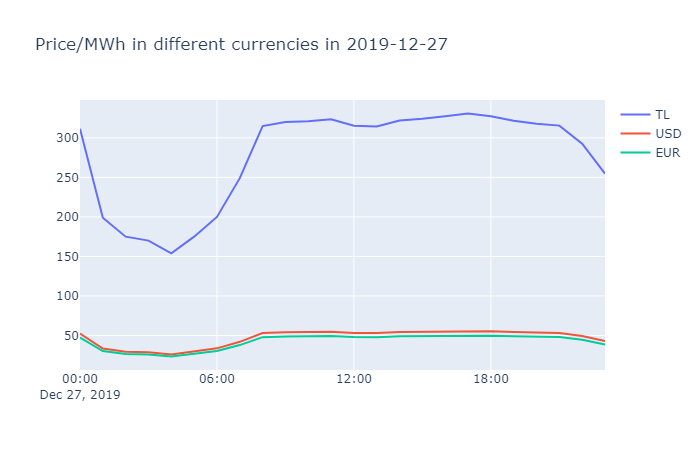

In [29]:
sample_day = price_df.sample().index[0].strftime('%Y-%m-%d')
fig_df = price_df.loc[sample_day].copy()
fig = go.Figure()
for col in fig_df:
    fig.add_trace(go.Scatter(y=fig_df[col], x=fig_df.index, name=col))
fig.update_layout(
    hovermode="x",
    title=f'Price/MWh in different currencies in {sample_day}'
)
fig.show()

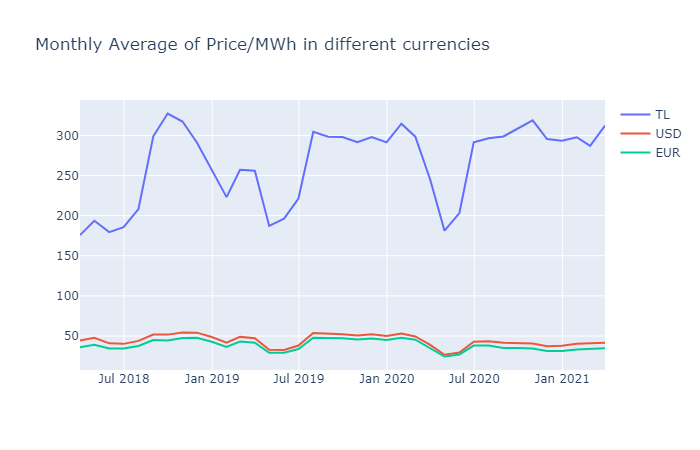

In [30]:
fig_df = price_df.groupby(pd.Grouper(freq='M')).mean()
fig = go.Figure()
for col in fig_df:
    fig.add_trace(go.Scatter(y=fig_df[col], x=fig_df.index, name=col))
fig.update_layout(hovermode="x", title='Monthly Average of Price/MWh in different currencies')
fig.show()

### Get Hourly seperated dataframes

In [7]:
# Hourly Dataframes
## concatenate each hour's dataset vertically
get_hourly_df = lambda df, column: df.groupby(df.index.hour)[column].apply(
    lambda col: col.to_dict()).to_frame().dropna()

hourly_load_df = get_hourly_df(load_df, 'Load_Forecast_MWh')
hourly_price_df = pd.concat(
    [ get_hourly_df(price_df, col) for col in price_df ],
    axis=1
)
hourly_holiday_df = get_hourly_df(get_holiday(price_df), 'Holiday')
hourly_min_price_l1 = pd.concat(
    [get_hourly_df(price_df.resample('D').transform('min').shift(24), col) for col in price_df],
    axis=1
)
hourly_min_price_l1.rename(columns={x: f"{x}_min_l1" for x in hourly_min_price_l1.columns}, inplace=True)

hourly_weekday_df = hourly_price_df.assign(
    Saturday = lambda df: (df.index.get_level_values(1).day_of_week == 5) * 1,
    Sunday = lambda df: (df.index.get_level_values(1).day_of_week == 6) * 1,
    Monday = lambda df: (df.index.get_level_values(1).day_of_week == 0) * 1,
).filter(regex='day')

In [8]:
hourly_load_df

Load_Forecast_MWh
0  2018-04-01 00:00:00+03:00            30500.0
   2018-04-02 00:00:00+03:00            29400.0
   2018-04-03 00:00:00+03:00            31900.0
   2018-04-04 00:00:00+03:00            31600.0
   2018-04-05 00:00:00+03:00            31700.0
...                                         ...
23 2021-03-24 23:00:00+03:00            36378.0
   2021-03-25 23:00:00+03:00            36639.0
   2021-03-26 23:00:00+03:00            36496.0
   2021-03-27 23:00:00+03:00            34896.0
   2021-03-28 23:00:00+03:00            34007.0

[26232 rows x 1 columns]

In [9]:
hourly_price_df

TL    USD    EUR
0  2018-03-25 00:00:00+03:00  214.21  54.08  43.85
   2018-03-26 00:00:00+03:00  179.80  45.39  36.80
   2018-03-27 00:00:00+03:00  169.21  42.58  34.36
   2018-03-28 00:00:00+03:00  189.11  47.57  38.27
   2018-03-29 00:00:00+03:00  183.10  45.85  36.99
...                              ...    ...    ...
23 2021-03-24 23:00:00+03:00  280.54  35.49  29.82
   2021-03-25 23:00:00+03:00  280.00  35.86  30.14
   2021-03-26 23:00:00+03:00  293.99  36.90  31.19
   2021-03-27 23:00:00+03:00  311.01  39.17  33.16
   2021-03-28 23:00:00+03:00  248.98  31.16  26.45

[26400 rows x 3 columns]

#### Stationarity Check

In [10]:
# Prices
adfuller_price = hourly_price_df.groupby(
    level=0, axis=0
) \
.apply(
    lambda hour: hour.apply(lambda col: adfuller(col)).apply(pd.Series).T
)\
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values'
})
print('Non-stationary hour series:', adfuller_price.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary hour series: [(0, 'TL') (0, 'USD') (0, 'EUR') (1, 'EUR') (3, 'TL') (3, 'USD')
 (3, 'EUR') (4, 'TL') (4, 'USD') (4, 'EUR') (5, 'TL') (5, 'USD')
 (5, 'EUR') (6, 'TL') (6, 'USD') (6, 'EUR') (7, 'TL') (7, 'USD')
 (7, 'EUR') (8, 'TL') (8, 'USD') (8, 'EUR') (9, 'TL') (9, 'USD')
 (9, 'EUR') (10, 'TL') (10, 'USD') (10, 'EUR') (11, 'TL') (11, 'USD')
 (11, 'EUR') (12, 'TL') (12, 'USD') (12, 'EUR') (13, 'TL') (13, 'USD')
 (13, 'EUR') (14, 'TL') (14, 'USD') (14, 'EUR') (15, 'TL') (15, 'USD')
 (15, 'EUR') (16, 'TL') (16, 'USD') (16, 'EUR') (17, 'TL') (17, 'USD')
 (17, 'EUR') (18, 'TL') (18, 'USD') (18, 'EUR') (19, 'USD') (19, 'EUR')
 (20, 'TL') (20, 'USD') (20, 'EUR') (21, 'TL') (21, 'USD') (21, 'EUR')
 (22, 'TL') (22, 'USD') (22, 'EUR') (23, 'TL') (23, 'USD') (23, 'EUR')]


In [11]:
# Load Forecast
adfuller_load = hourly_load_df.groupby(
    level=0, axis=0
) \
.apply(adfuller).apply(pd.Series) \
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values'
})
print('Non-stationary hour series:', adfuller_load.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary hour series: [ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23]


In [12]:
# Min Prices lag 1
adfuller_min_l1 = hourly_min_price_l1.groupby(
    level=0, axis=0
) \
.apply(
    lambda hour: hour.apply(lambda col: adfuller(col)).apply(pd.Series).T
)\
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values'
})
print('Non-stationary hour series:', adfuller_min_l1.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary hour series: [(0, 'TL_min_l1') (0, 'USD_min_l1') (0, 'EUR_min_l1') (1, 'TL_min_l1')
 (1, 'USD_min_l1') (1, 'EUR_min_l1') (2, 'TL_min_l1') (2, 'USD_min_l1')
 (2, 'EUR_min_l1') (3, 'TL_min_l1') (3, 'USD_min_l1') (3, 'EUR_min_l1')
 (4, 'TL_min_l1') (4, 'USD_min_l1') (4, 'EUR_min_l1') (5, 'TL_min_l1')
 (5, 'USD_min_l1') (5, 'EUR_min_l1') (6, 'TL_min_l1') (6, 'USD_min_l1')
 (6, 'EUR_min_l1') (7, 'TL_min_l1') (7, 'USD_min_l1') (7, 'EUR_min_l1')
 (8, 'TL_min_l1') (8, 'USD_min_l1') (8, 'EUR_min_l1') (9, 'TL_min_l1')
 (9, 'USD_min_l1') (9, 'EUR_min_l1') (10, 'TL_min_l1') (10, 'USD_min_l1')
 (10, 'EUR_min_l1') (11, 'TL_min_l1') (11, 'USD_min_l1')
 (11, 'EUR_min_l1') (12, 'TL_min_l1') (12, 'USD_min_l1')
 (12, 'EUR_min_l1') (13, 'TL_min_l1') (13, 'USD_min_l1')
 (13, 'EUR_min_l1') (14, 'TL_min_l1') (14, 'USD_min_l1')
 (14, 'EUR_min_l1') (15, 'TL_min_l1') (15, 'USD_min_l1')
 (15, 'EUR_min_l1') (16, 'TL_min_l1') (16, 'USD_min_l1')
 (16, 'EUR_min_l1') (17, 'TL_min_l1') (17, 'USD_min_l1'

All series are non-stationary, thus we take the **1st** difference and check again.

In [13]:
# Prices (1st difference)
adfuller_price = hourly_price_df.groupby(
    level=0, axis=0
) \
.apply(
    lambda hour: hour.apply(lambda col: adfuller(
        col.diff(1).dropna() # get 1st difference for each series
    )).apply(pd.Series).T
)\
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values'
})
print('Non-stationary differenced hour series:', adfuller_price.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary differenced hour series: []


In [14]:
# Load Forecast
adfuller_load = hourly_load_df.groupby(
    level=0, axis=0
) \
.apply(
    lambda hour: hour.diff(1).dropna() # get 1st difference for each series
) \
.apply(adfuller).apply(pd.Series).T \
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values' 
})
print('Non-stationary differenced hour series:', adfuller_load.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary differenced hour series: []


In [15]:
# Min Prices lag 1
adfuller_min_l1 = hourly_min_price_l1.groupby(
    level=0, axis=0
) \
.apply(
    lambda hour: hour.apply(lambda col: adfuller(col.diff(1).dropna())).apply(pd.Series).T
)\
.drop(columns=[5]) \
.rename(columns={
    0:'ADF Stat', 1: 'p-value', 2: 'n_lags',
    3:'n_observation', 4: 'Critical Values'
})
print('Non-stationary differenced hour series:', adfuller_min_l1.loc[lambda df: df['p-value'] > 0.005].index.values)

Non-stationary differenced hour series: []


#### Construct dataframe to use with differenced series

In [16]:
currency = 'EUR' # 'MCP (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh)
main_df = pd.concat([
    hourly_price_df[currency].to_frame(name='Price_MWh').groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_load_df.groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_min_price_l1.filter(regex=currency).rename(columns={f"{currency}_min_l1": "Price_MWh_min_l1"})
    .groupby(level=0, axis=0).apply(lambda hour: hour.diff(1)),
    hourly_holiday_df,
    hourly_weekday_df
    ], axis=1
)

price_df_final = price_df[currency].to_frame(name='Price_MWh')

In [17]:
main_df.dropna()

Price_MWh  Load_Forecast_MWh  Price_MWh_min_l1  \
0  2018-04-02 00:00:00+03:00     -10.19            -1100.0            -19.52   
   2018-04-03 00:00:00+03:00      19.93             2500.0             12.50   
   2018-04-04 00:00:00+03:00      -0.49             -300.0             16.17   
   2018-04-05 00:00:00+03:00      -0.29              100.0             -9.29   
   2018-04-06 00:00:00+03:00      -0.09              100.0             -0.15   
...                                 ...                ...               ...   
23 2021-03-24 23:00:00+03:00       4.61              -16.0             -2.25   
   2021-03-25 23:00:00+03:00       0.32              261.0              0.07   
   2021-03-26 23:00:00+03:00       1.05             -143.0              0.24   
   2021-03-27 23:00:00+03:00       1.97            -1600.0             -1.67   
   2021-03-28 23:00:00+03:00      -6.71             -889.0              0.13   

                              Holiday  Saturday  Sunday  Monday  
0  2018-04-02 00:00:00+03:00      0.0         0       0       1  
   2018-04-03 00:00:00+03:00      0.0         0       0       0  
   2018-04-04 00:00:00+03:00      0.0         0       0       0  
   2018-04-05 00:00:00+03:00      0.0         0       0       0  
   2018-04-06 00:00:00+03:00      0.0         0       0       0  
...                               ...       ...     ...     ...  
23 2021-03-24 23:00:00+03:00      0.0         0       0       0  
   2021-03-25 23:00:00+03:00      0.0         0       0       0  
   2021-03-26 23:00:00+03:00      0.0         0       0       0  
   2021-03-27 23:00:00+03:00      0.0         1       0       0  
   2021-03-28 23:00:00+03:00      0.0         0       1       0  

[26208 rows x 7 columns]